In [13]:
import os, sys
sys.path.append('C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing')
from lib import *

In [4]:
train_dir = 'C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/data/train'
test_dir = 'C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/data/test'
model = CNN().cuda()
criterion = CrossEntropyLoss()
model.load_state_dict(torch.load('C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/weight/best_weight_final.pth'))
test_dataset = Covid_XRay(split='test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']

def count_images(directory):
    counts = {}
    for category in categories:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

def plot_distribution(train_counts, test_counts):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].bar(train_counts.keys(), train_counts.values(), color=['blue', 'green', 'red'])
    ax[0].set_title('Train Dataset Distribution')
    ax[0].set_xlabel('Category')
    ax[0].set_ylabel('Number of Images')

    ax[1].bar(test_counts.keys(), test_counts.values(), color=['blue', 'green', 'red'])
    ax[1].set_title('Test Dataset Distribution')
    ax[1].set_xlabel('Category')
    ax[1].set_ylabel('Number of Images')
    
    plt.show()

def show_samples(directory):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, category in enumerate(categories):
        category_dir = os.path.join(directory, category)
        img_name = os.listdir(category_dir)[0] 
        img_path = os.path.join(category_dir, img_name)
        img = Image.open(img_path)
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(category)
        ax[i].axis('off')
    plt.show()

def image_size_distribution(directory):
    image_sizes = []
    for category in categories:
        category_dir = os.path.join(directory, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            with Image.open(img_path) as img:
                image_sizes.append(img.size)
    
    widths, heights = zip(*image_sizes)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='blue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='green')
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.show()



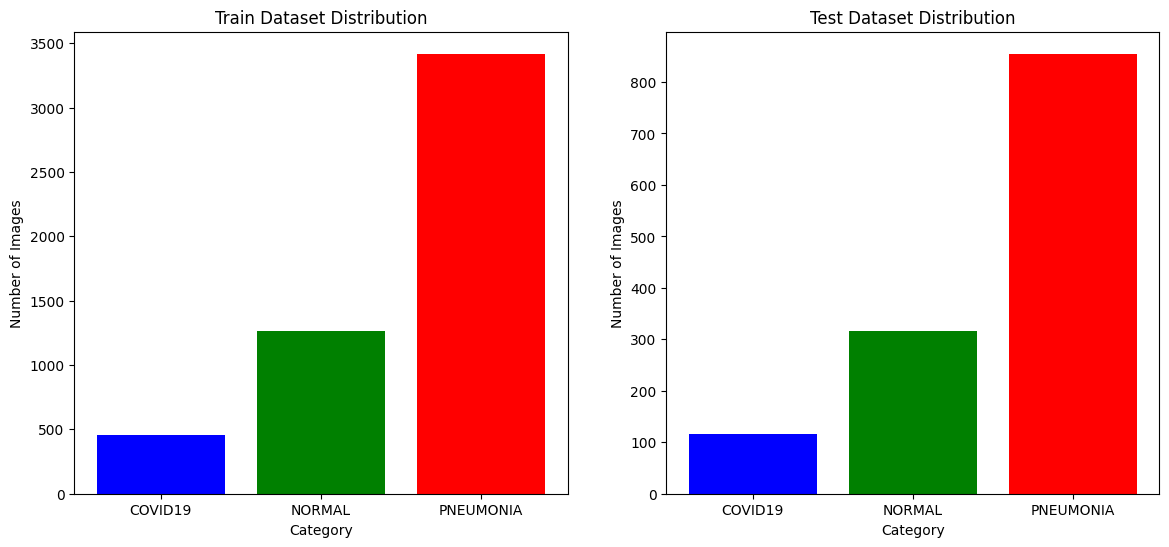

In [6]:
plot_distribution(train_counts, test_counts)


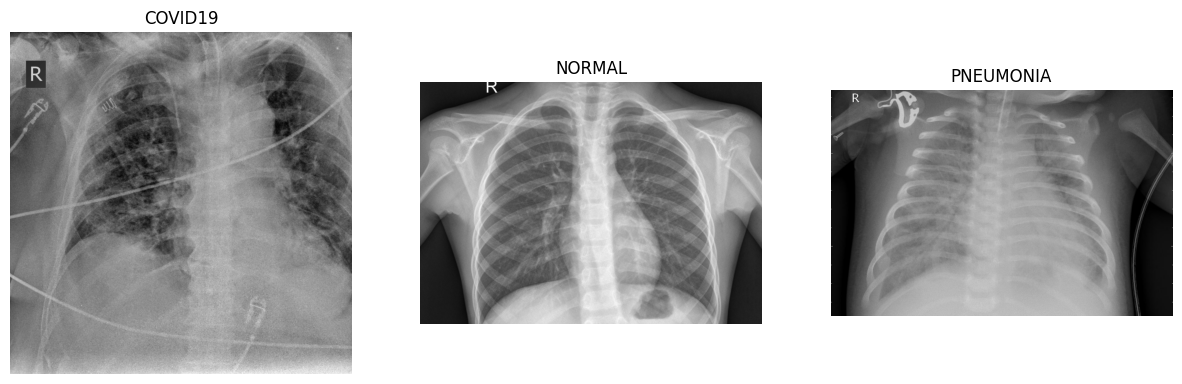

In [7]:
show_samples(train_dir)

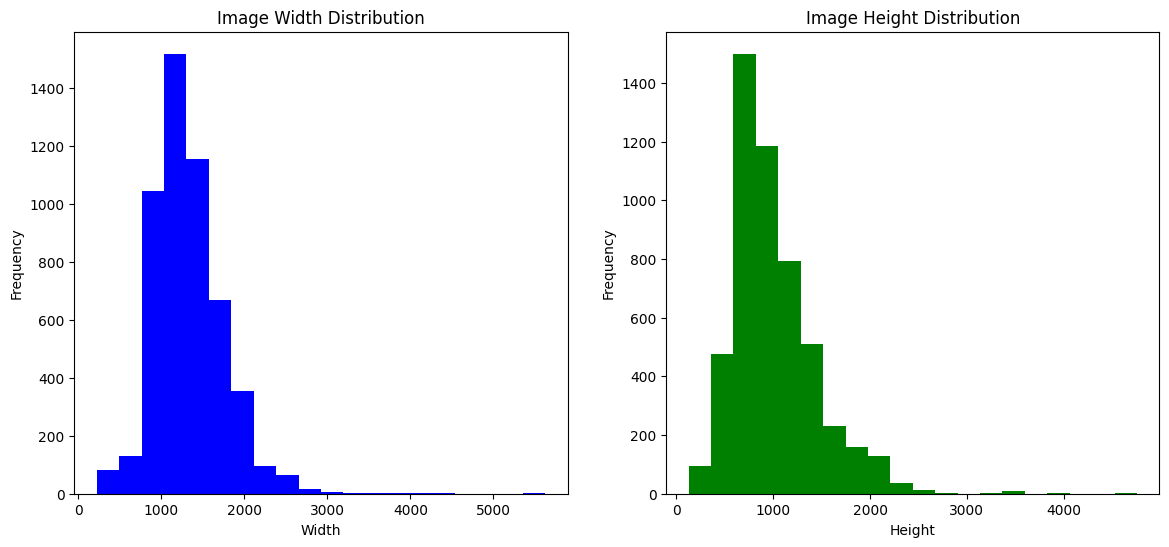

In [8]:
image_size_distribution(train_dir)

In [6]:
from score import evaluate
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Score - Loss: 0.1433, Accuracy: 0.9495
Precision: 0.9497, Recall: 0.9495, F1 Score: 0.9488
Confusion Matrix:
[[109   2   5]
 [  2 272  43]
 [  0  13 842]]
Confusion Matrix, without Normalization


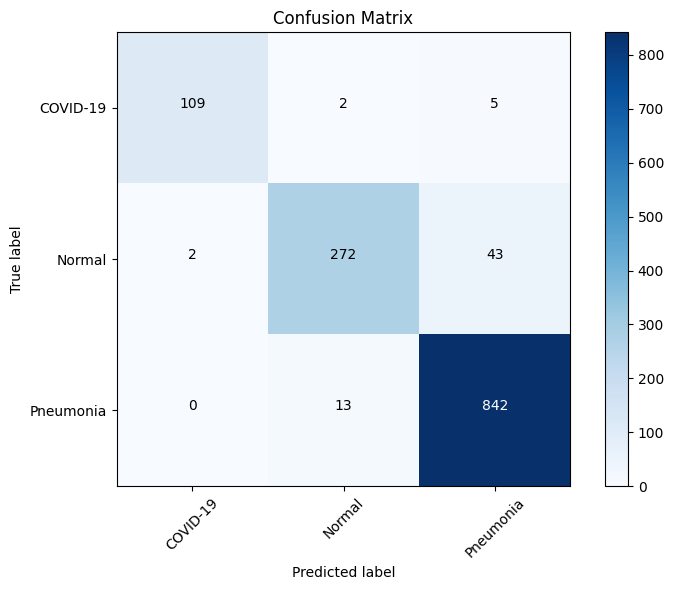

In [7]:
def main():
    avg_loss, accuracy, precision, recall, f1, conf_matrix = evaluate(model, criterion, test_dataloader)
    classes = ['COVID-19', 'Normal', 'Pneumonia']
    plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix')
    all_labels = np.array([label for _, label in test_dataset]) 

if __name__ == '__main__':
    main()

0: COVID19

1: NORMAL

2: PNEUMONIA


In [21]:
def show_predictions(images, preds, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"Pred: {preds[i]}")
        ax.axis('off')

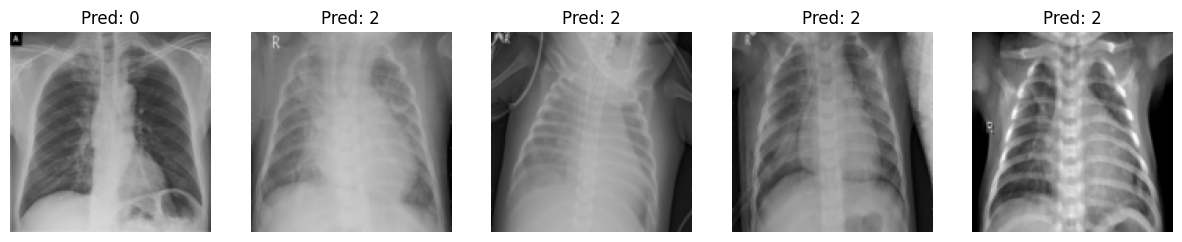

In [11]:
random_indices = random.sample(range(len(test_dataset)), 5)
selected_images = []
selected_labels = []

for index in random_indices:
    img, label = test_dataset[index]
    selected_images.append(img.unsqueeze(0))  
    selected_labels.append(label)

selected_images = torch.cat(selected_images)
selected_images = selected_images.cuda()
outputs = model(selected_images)
_, preds = torch.max(outputs, 1)
show_predictions(selected_images.cpu(), selected_labels, preds.cpu().numpy(), num_images=5)
plt.show()


# Convert to ONNX and TensorRT

Run only once

In [13]:
model = CNN()
model.load_state_dict(torch.load("C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/weight/best_weight_final.pth"))

dummy_input = torch.randn(1, 3, 128, 128)
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True, opset_version=11)


In [12]:
onnx_model_path = "C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

dummy_input = torch.randn(1, 3, 128, 128).numpy()
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input}

ort_outs = ort_session.run(None, ort_inputs)
print("ONNX model output:", ort_outs)


ONNX model output: [array([[ 37.919483 , -24.568146 ,   3.0065565]], dtype=float32)]


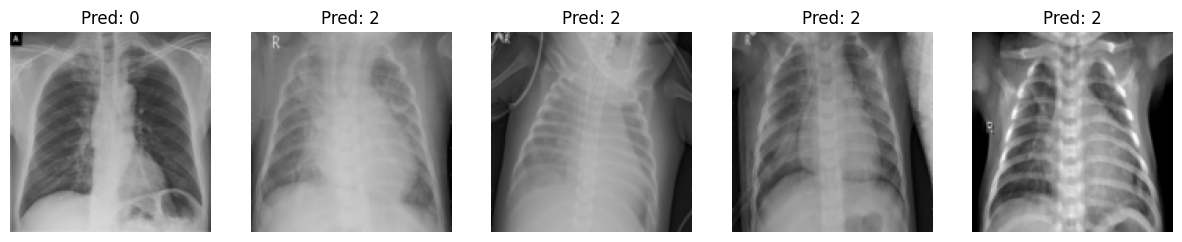

In [23]:
selected_images = []
selected_labels = []
predictions = []

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
])
test_dataset = Covid_XRay(split='test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for index in random_indices:
    img, label = test_dataset[index]
    selected_images.append(img)  
    selected_labels.append(label)

    img_np = img.numpy().transpose(1, 2, 0)  
    img_np = transform(Image.fromarray((img_np * 255).astype(np.uint8)))  
    img_np = img_np.unsqueeze(0).numpy().astype(np.float32)  

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}
    ort_outs = ort_session.run(None, ort_inputs)
    preds = np.argmax(ort_outs[0], axis=1)
    predictions.append(preds[0])  


show_predictions(torch.stack(selected_images), predictions, num_images=5)
plt.show()

# Inference with TensorRT

In [ ]:
engine = load_engine("C:/Users/flori/OneDrive/Máy tính/Tai-lieu/HCMUS/Image processing/model.trt")
h_input, h_output, d_input, d_output, stream = allocate_buffers(engine)
output = do_inference(engine, h_input, d_input, h_output, d_output, stream)